In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [2]:
# Install necessary libraries
!pip install efficientnet keras
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [9]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pywt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [3]:
#Load metadata
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [5]:
# Map 7 classes into 2 classes: Benign and Malignant
benign_classes = ['nv', 'bkl', 'df', 'vasc']
malignant_classes = ['mel', 'bcc', 'akiec']

def map_binary(label):
    return 'benign' if label in benign_classes else 'malignant'

metadata['binary_label'] = metadata['dx'].apply(map_binary)

In [10]:
# Encode labels
label_encoder = LabelEncoder()
metadata['label_encoded'] = label_encoder.fit_transform(metadata['binary_label'])

In [11]:
# First split into train_val and test
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(metadata, test_size=0.1, random_state=42, stratify=metadata['label_encoded'])

# Then split train_val into train and validation
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label_encoded'])

In [12]:
# Function: Apply DWT
def dwt2_transform(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    coeffs2 = pywt.dwt2(img_gray, 'haar')
    LL, (LH, HL, HH) = coeffs2 
    return LL

In [13]:
# Memory-efficient Data Generator
class DataGenerator(Sequence):
    def __init__(self, df, batch_size=32, img_size=(224,224), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        
        X = np.empty((len(batch_df), *self.img_size, 3), dtype=np.float32)
        y = np.empty((len(batch_df),), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_id = row['image_id']
            label = row['label_encoded']
            
            path1 = f'/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{img_id}.jpg'
            path2 = f'/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/{img_id}.jpg'
            
            img_path = path1 if os.path.exists(path1) else path2
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = cv2.GaussianBlur(img, (5,5), 0)        # Gaussian filtering
            
            img_dwt = dwt2_transform(img)
            img_dwt = cv2.resize(img_dwt, self.img_size)
            img_dwt = np.stack((img_dwt,)*3, axis=-1)  # 3-channel
            
            X[i,] = img_dwt / 255.0  # Normalize
            y[i] = label
            
        return X, y



In [14]:
# Initialize generators
batch_size = 32
train_gen = DataGenerator(train_df, batch_size=batch_size)
val_gen = DataGenerator(val_df, batch_size=batch_size, shuffle=False)
test_gen = DataGenerator(test_df, batch_size=batch_size)

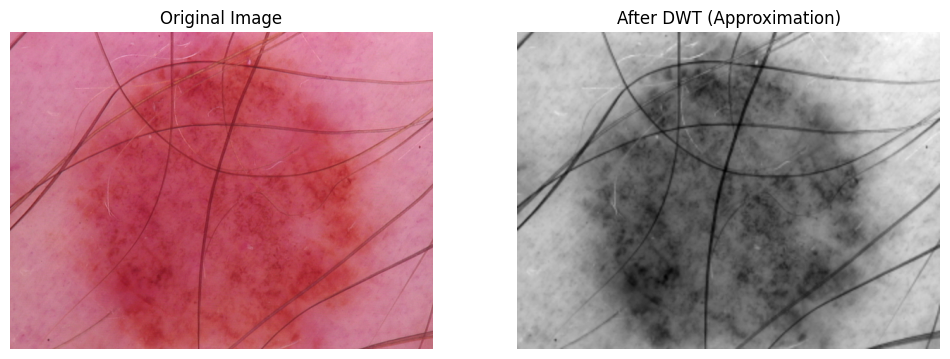

In [15]:
# Example: load one image
img_id = test_df.iloc[0]['image_id']  # take first image from test_df

# Image paths
path1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + img_id + '.jpg'
path2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + img_id + '.jpg'

if os.path.exists(path1):
    img_path = path1
else:
    img_path = path2

# 1. Load the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. Perform DWT
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
coeffs2 = pywt.dwt2(img_gray, 'haar')
LL, (LH, HL, HH) = coeffs2
img_dwt = LL  # Using only Approximation coefficients

# Resize DWT to original size for better comparison (optional)
img_dwt_resized = cv2.resize(img_dwt, (img.shape[1], img.shape[0]))

# 3. Plot side-by-side
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# After DWT
plt.subplot(1, 2, 2)
plt.imshow(img_dwt_resized, cmap='gray')
plt.title('After DWT (Approximation)')
plt.axis('off')

plt.show()

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmenter = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

def train_with_augmentation(generator, augmenter):
    while True:
        X_batch, y_batch = generator.__getitem__(np.random.randint(0, len(generator)))
        aug_iter = augmenter.flow(X_batch, batch_size=X_batch.shape[0], shuffle=False)
        X_batch_augmented = next(aug_iter)
        yield X_batch_augmented, y_batch

train_augmented_gen = train_with_augmentation(train_gen, augmenter)

In [19]:
# Build EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

In [20]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_augmented_gen,
    steps_per_epoch=len(train_gen),
    epochs=15,
    validation_data=val_gen,
    verbose=1
)

Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 155s 689ms/step - accuracy: 0.8877 - loss: 0.2507 - val_accuracy: 0.8286 - val_loss: 0.6600
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 153s 681ms/step - accuracy: 0.9004 - loss: 0.2377 - val_accuracy: 0.8719 - val_loss: 0.3501
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 151s 672ms/step - accuracy: 0.9075 - loss: 0.2201 - val_accuracy: 0.8780 - val_loss: 0.3304
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 150s 664ms/step - accuracy: 0.9235 - loss: 0.1927 - val_accuracy: 0.8774 - val_loss: 0.3256
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 648ms/step - accuracy: 0.9294 - loss: 0.1759 - val_accuracy: 0.8885 - val_loss: 0.3339
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 141s 623ms/step - accuracy: 0.9432 - loss: 0.1406 - val_accuracy: 0.8747 - val_loss: 0.4202
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 140s 623ms/step - accuracy: 0.9572 - loss: 0.1104 - val_accuracy: 0.8724 - val_loss: 0.3653
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 140s 622ms/step - accuracy: 0.9546 -

In [24]:
# Unfreeze the base model
base_model.trainable = True

# Optionally, freeze earlier layers (like first 80%) and unfreeze last few layers
for layer in base_model.layers[:-30]:  # Keep first layers frozen
    layer.trainable = False

# Re-compile with a low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_augmented_gen,
    steps_per_epoch=len(train_gen),
    epochs=10,  # smaller number of epochs here
    validation_data=val_gen,
    verbose=1
)


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 226s 799ms/step - accuracy: 0.9783 - loss: 0.0572 - val_accuracy: 0.8824 - val_loss: 0.4398
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 150s 667ms/step - accuracy: 0.9790 - loss: 0.0589 - val_accuracy: 0.8830 - val_loss: 0.4359
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 148s 659ms/step - accuracy: 0.9808 - loss: 0.0516 - val_accuracy: 0.8835 - val_loss: 0.4312
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 144s 640ms/step - accuracy: 0.9776 - loss: 0.0600 - val_accuracy: 0.8846 - val_loss: 0.4300
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 138s 615ms/step - accuracy: 0.9841 - loss: 0.0455 - val_accuracy: 0.8885 - val_loss: 0.4332
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 139s 615ms/step - accuracy: 0.9834 - loss: 0.0473 - val_accuracy: 0.8874 - val_loss: 0.4377
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 137s 609ms/step - accuracy: 0.9811 - loss: 0.0519 - val_accuracy: 0.8880 - val_loss: 0.4371
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 139s 616ms/step - accuracy: 0.9817 -

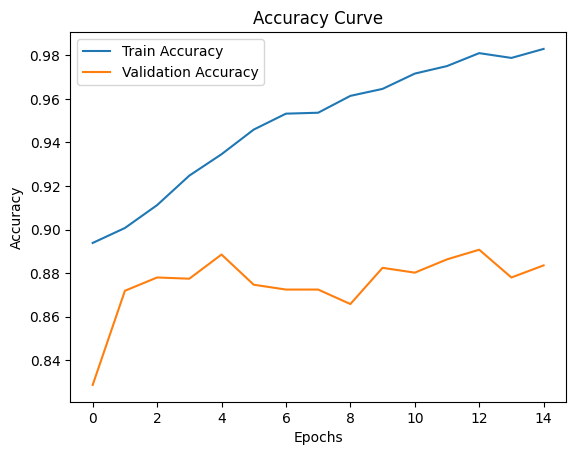

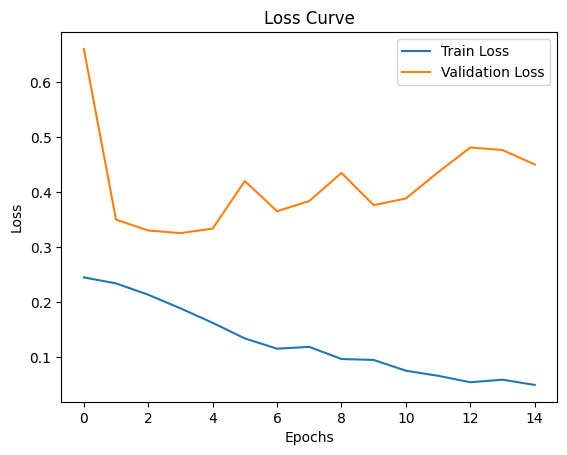

In [25]:
# 1. Plot Accuracy and Loss Curves
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
y_true = val_df['label_encoded'].values
y_pred_probs = model.predict(val_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 481ms/step
Accuracy : 0.8902
Precision: 0.7484
Recall   : 0.6591
F1 Score : 0.7009


In [28]:
#Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.8782 - loss: 0.4869
Test Loss: 0.4697
Test Accuracy: 0.8772


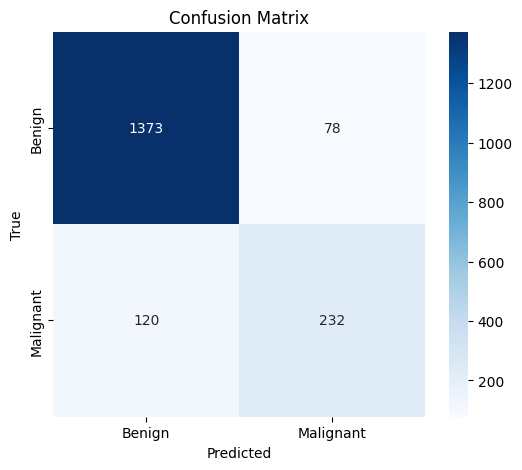

In [29]:
# 5. Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
def preprocess_image(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)

    # Apply DWT
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    coeffs2 = pywt.dwt2(img_gray, 'haar')
    LL, (LH, HL, HH) = coeffs2
    img_dwt = cv2.resize(LL, img_size)
    img_dwt = np.stack((img_dwt,)*3, axis=-1)  # Make it 3-channel

    img_dwt = img_dwt / 255.0  # Normalize
    img_dwt = np.expand_dims(img_dwt, axis=0)  # Add batch dimension
    return img_dwt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


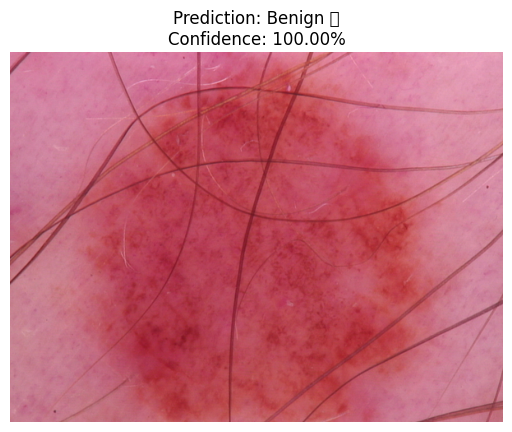

Predicted Class: Benign 🌼
Prediction Confidence: 100.00%


In [32]:
# Example: Pick an image from test set
img_id = test_df.iloc[0]['image_id']  # Pick first image (you can change index)
path1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + img_id + '.jpg'
path2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + img_id + '.jpg'

if os.path.exists(path1):
    img_path = path1
else:
    img_path = path2

# Preprocess and Predict
img = preprocess_image(img_path)
prediction = model.predict(img)

# Decide label
predicted_class = "Malignant 🔥" if prediction[0][0] > 0.5 else "Benign 🌼"
confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

# Load original image for display
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Plot
plt.imshow(original_img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence*100:.2f}%")
plt.show()

# Also print in console
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {confidence*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


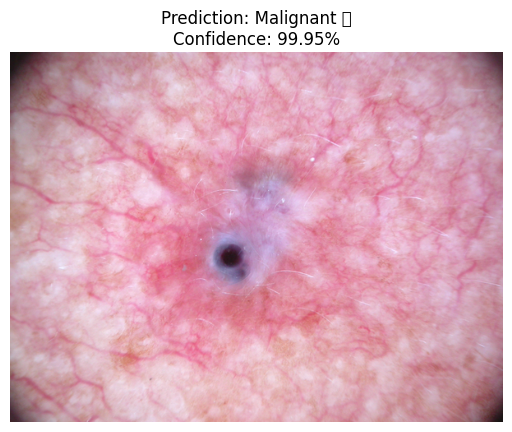

Predicted Class: Malignant 🔥
Prediction Confidence: 99.95%


In [34]:
# Example: Pick an image from test set
img_id = test_df.iloc[27]['image_id']  # Pick first image (you can change index)
path1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + img_id + '.jpg'
path2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + img_id + '.jpg'

if os.path.exists(path1):
    img_path = path1
else:
    img_path = path2

# Preprocess and Predict
img = preprocess_image(img_path)
prediction = model.predict(img)

# Decide label
predicted_class = "Malignant 🔥" if prediction[0][0] > 0.5 else "Benign 🌼"
confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

# Load original image for display
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Plot
plt.imshow(original_img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence*100:.2f}%")
plt.show()

# Also print in console
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {confidence*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


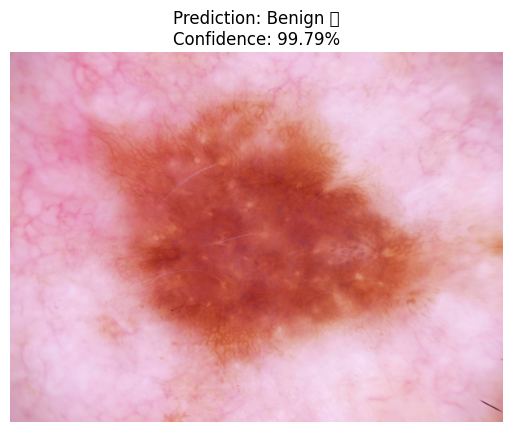

Predicted Class: Benign 🌼
Prediction Confidence: 99.79%


In [35]:
# Example: Pick an image from test set
img_id = test_df.iloc[1]['image_id']  # Pick first image (you can change index)
path1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + img_id + '.jpg'
path2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + img_id + '.jpg'

if os.path.exists(path1):
    img_path = path1
else:
    img_path = path2

# Preprocess and Predict
img = preprocess_image(img_path)
prediction = model.predict(img)

# Decide label
predicted_class = "Malignant 🔥" if prediction[0][0] > 0.5 else "Benign 🌼"
confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

# Load original image for display
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Plot
plt.imshow(original_img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence*100:.2f}%")
plt.show()

# Also print in console
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {confidence*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


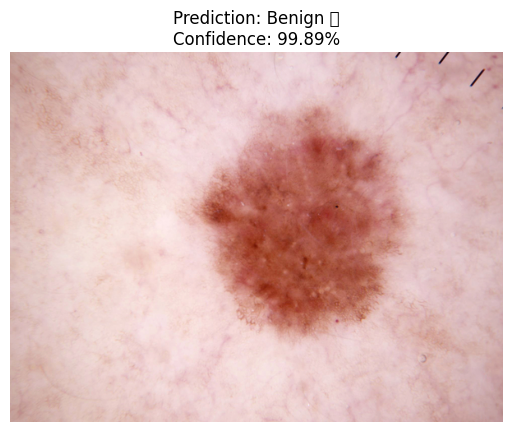

Predicted Class: Benign 🌼
Prediction Confidence: 99.89%


In [36]:
# Example: Pick an image from test set
img_id = test_df.iloc[4]['image_id']  # Pick first image (you can change index)
path1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + img_id + '.jpg'
path2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + img_id + '.jpg'

if os.path.exists(path1):
    img_path = path1
else:
    img_path = path2

# Preprocess and Predict
img = preprocess_image(img_path)
prediction = model.predict(img)

# Decide label
predicted_class = "Malignant 🔥" if prediction[0][0] > 0.5 else "Benign 🌼"
confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

# Load original image for display
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Plot
plt.imshow(original_img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence*100:.2f}%")
plt.show()

# Also print in console
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Confidence: {confidence*100:.2f}%")